In [5]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import datetime
from models import Autoencoder
from datasets import DeepfakeDataset
import train_autoencoder
import test_autoencoder

rcParams.update({
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
        'figure.figsize': (7.5,5),
})
def file_str():
    """ Auto-generates file name."""
    now = datetime.datetime.now()
    return now.strftime("H%HM%MS%S_%f_%m-%d-%y")
def pdf_savefig():
    fname = file_str()
    plt.savefig(f"./figs/{fname}.pdf")
    plt.close()

EPOCH_SIZE = 50
offset_range = range(0, 9, 2)

train_errs = list()
train_times = list()
test_errs = list()
test_times = list()
hidden_dims = list()

for offset in offset_range:
    train_err, train_exec_time = train_autoencoder.train_autoencoder(n_out_channels1=8+offset, n_out_channels2=8+offset, n_out_channels3=4+offset, kernel_size=5, epoch_size=EPOCH_SIZE)
    train_errs.append(train_err)
    train_times.append(train_exec_time)
    test_err, test_exec_time, hidden_dim = test_autoencoder.test_autoencoder(n_out_channels1=8+offset, n_out_channels2=8+offset, n_out_channels3=4+offset, kernel_size=5)
    test_errs.append(test_err)
    test_times.append(test_exec_time)
    hidden_dims.append(hidden_dim)

train_encoder start time: 2020-04-23 11:54:44.968096
Using device: cuda
epoch: 0, loss: 0.1533864438533783, executed in: 0:00:09.291601


RuntimeError: stack expects a non-empty TensorList

Text(0, 0.5, 'Mean squared error')

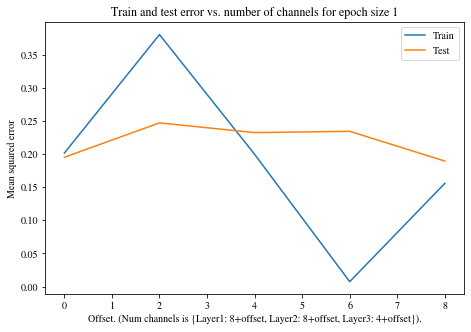

In [4]:
plt.plot(list(offset_range), train_errs, label=f"Train")
plt.plot(list(offset_range), test_errs, label=f"Test")
plt.title(f"Train and test error vs. number of channels for epoch size {EPOCH_SIZE}")
plt.legend(loc=0)
plt.xlabel("Offset. (Num channels is {Layer1: 8+offset, Layer2: 8+offset, Layer3: 4+offset}).")
plt.ylabel("Mean squared error")

In [23]:
import glob
import os
import numpy as np
with torch.no_grad():
    test_folder = [
        'test/test_videos',
    ]
    test_dataset = DeepfakeDataset(test_folder, n_frames=1, train=False)

    model = Autoencoder(n_out_channels1=10, n_out_channels2=10, n_out_channels3=6, kernel_size=5)
    criterion = nn.MSELoss()

    latest_ae = max(glob.glob('./*.pt'), key=os.path.getctime)
    model.load_state_dict(torch.load(latest_ae))

    num_vids = len(glob.glob(test_folder[0]+"/*"))
    sample_size = 40
    sample = np.random.choice(a=num_vids, size=sample_size, replace=False)

    loss = 0
    for ind in sample:
        data = test_dataset[ind]
        out = model(data)
        loss += criterion(out, data).item()
    hidden = model.encode(data)
(loss / sample_size, np.prod(list(hidden.size())))

NameError: name 'exec_time' is not defined

In [24]:
hidden.size()

torch.Size([1, 6, 270, 480])

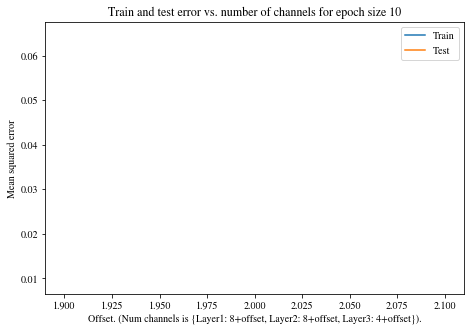

In [25]:
# NUM CHANNELS: ERR
plt.plot(list(offset_range), train_errs, label=f"Train")
plt.plot(list(offset_range), test_errs, label=f"Test")
plt.title(f"Train and test error vs. number of channels for epoch size {EPOCH_SIZE}")
plt.legend(loc=0)
plt.xlabel("Offset. (Num channels is {Layer1: 8+offset, Layer2: 8+offset, Layer3: 4+offset}).")
plt.ylabel("Mean squared error")
plt.show()



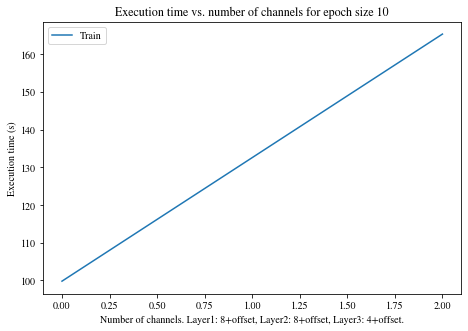

NameError: name 'start_time' is not defined

In [10]:
# NUM CHANNELS: TIMES
plt.plot(list(offset_range), [train_time.total_seconds() for train_time in train_times], label=f"Train")
plt.title(f"Execution time vs. number of channels for epoch size {EPOCH_SIZE}")
plt.legend(loc=0)
plt.xlabel("Offset. (Num channels is {Layer1: 8+offset, Layer2: 8+offset, Layer3: 4+offset}).")
plt.ylabel("Execution time (s)")
plt.show()

# DIM REDUCTION



In [16]:
hidden_dims

[6220800, 6220800]

No handles with labels found to put in legend.


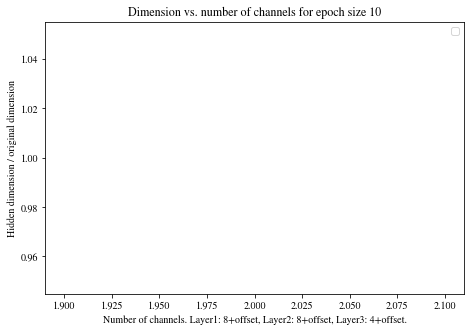

In [27]:
plt.plot(list(offset_range), [hidden_dim/(3*1920*1080) for hidden_dim in hidden_dims])
plt.title(f"Dimension vs. number of channels for epoch size {EPOCH_SIZE}")
plt.xlabel("Number of channels. Layer1: 8+offset, Layer2: 8+offset, Layer3: 4+offset.")
plt.ylabel("Hidden dimension / original dimension")
pdf_savefig()

In [29]:
epoch_range = range(10, 21, 10)

train_errs = list()
train_times = list()
test_errs = list()
test_times = list()

for epoch in epoch_range:
    train_err, train_exec_time = train_autoencoder.train_autoencoder(n_out_channels1=12, n_out_channels2=12, n_out_channels3=6, kernel_size=5, epoch_size=epoch)
    train_errs.append(train_err)
    train_times.append(train_exec_time)
    test_err, test_exec_time, hidden_dim = test_autoencoder.test_autoencoder(n_out_channels1=12, n_out_channels2=12, n_out_channels3=6, kernel_size=5)
    test_errs.append(test_err)
    test_times.append(test_exec_time)


train_encoder start time: 2020-03-24 10:48:09.254081
epoch: 0, loss: 0.11570075899362564, executed in: 0:00:37.052747
epoch: 1, loss: 0.02627955563366413, executed in: 0:00:37.265024
epoch: 2, loss: 0.006593639962375164, executed in: 0:00:37.562464
epoch: 3, loss: 0.010536258108913898, executed in: 0:00:36.848647
epoch: 4, loss: 0.006503103766590357, executed in: 0:00:36.901074
train_encoder executed in: 0:03:05.641202, end time: 2020-03-24 10:51:14.895283
test_encoder start time: 2020-03-24 10:51:14.900939
executed in: 0:01:13.874002, finished 2020-03-24 10:52:28.774941
train_encoder start time: 2020-03-24 10:52:28.775915
epoch: 0, loss: 0.022606994956731796, executed in: 0:01:13.083088
epoch: 1, loss: 0.009543308988213539, executed in: 0:01:10.497973
epoch: 2, loss: 0.009792701341211796, executed in: 0:01:13.104646
epoch: 3, loss: 0.006248221732676029, executed in: 0:01:11.974295
epoch: 4, loss: 0.008435958996415138, executed in: 0:01:11.354804
train_encoder executed in: 0:06:00.0255

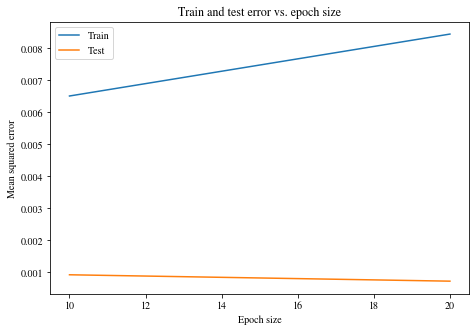

In [30]:
plt.plot(list(epoch_range), train_errs, label=f"Train")
plt.plot(list(epoch_range), test_errs, label=f"Test")
plt.title(f"Train and test error vs. epoch size")
plt.legend(loc=0)
plt.xlabel("Epoch size")
plt.ylabel("Mean squared error")
plt.show()

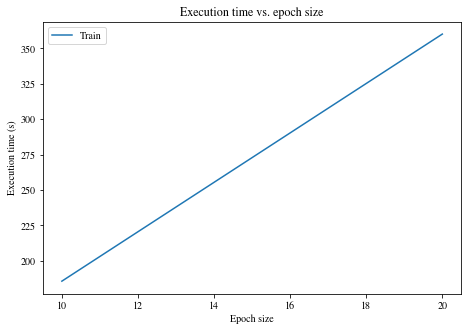

In [32]:
plt.plot(list(epoch_range), [train_time.total_seconds() for train_time in train_times], label=f"Train")
plt.title(f"Execution time vs. epoch size")
plt.legend(loc=0)
plt.xlabel("Epoch size")
plt.ylabel("Execution time (s)")
plt.show()

In [ ]:
import cv2
import itertools
import json
import numpy as np
import os.path
import torch

In [60]:
class CapIter:
    def __init__(self, cap, n_frames):
        self.cap = cap
        self.n_frames = n_frames
        self.i = 0
    def __iter__(self):
        return self
    def __next__(self):
        ok, frame = self.cap.read()
        if (ok and self.i < self.n_frames):
            self.i += 1
            return frame
        else:
            raise StopIteration

class DeepfakeDataset(torch.utils.data.Dataset):
    def __init__(self, folders, n_frames=float("inf")):
        self.n_frames = n_frames
        self.videos = []
        for folder in folders:
            with open(os.path.join(folder, 'metadata.json')) as f:
                videos = json.load(f)
                videos = [(os.path.join(folder, video), metadata) for (video, metadata) in videos.items()]
                self.videos += videos
    def __process_frame(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = torch.tensor(frame)
        frame = frame.permute(2, 0, 1)
        print(frame.size())
        frame = frame / 255.
        return frame
    def __getitem__(self, n):
        (video, metadata) = self.videos[n]
        cap = cv2.VideoCapture(video)
        it = CapIter(cap, self.n_frames)
        frames = list(map(self.__process_frame, it))
        cap.release()
        return (torch.stack(frames), metadata['label'])

    def __len__(self):
        return len(self.videos)

In [ ]:
train_folders = [
    'train/dfdc_train_part_0',
]
# train_dataset = DeepfakeDataset(train_folders)
train_dataset = DeepfakeDataset(train_folders, n_frames=1) # only load the first frame of every video
train_dataset[0]

In [59]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 5
batch_size = 1

In [57]:
# dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        if i * batch_size >= 10: # only train 100 videos per epoch
            break
        data, _ = batch
        data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], data.shape[3], data.shape[4])
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
    print(f'epoch: {epoch}, loss: {loss}')

torch.save(model.state_dict(), f'autoencoder{time.time()}.pt')

epoch: 0, loss: 0.09596087783575058


KeyboardInterrupt: 

In [3]:
import glob
import os

list_of_files = glob.glob('./*.pt') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

./autoencoder1584556558.0113933.pt


In [14]:
train_dataset[114]

number of frames 300


(tensor([[[[0.4667, 0.4824, 0.4824,  ..., 0.5373, 0.5412, 0.5451],
           [0.4627, 0.4706, 0.4706,  ..., 0.5373, 0.5412, 0.5451],
           [0.4471, 0.4588, 0.4588,  ..., 0.5412, 0.5451, 0.5451],
           ...,
           [0.2941, 0.2784, 0.2667,  ..., 0.6549, 0.6314, 0.6235],
           [0.2627, 0.2588, 0.2471,  ..., 0.6392, 0.6235, 0.6157],
           [0.2392, 0.2353, 0.2392,  ..., 0.6314, 0.6196, 0.6157]],
 
          [[0.5098, 0.5255, 0.5255,  ..., 0.5961, 0.6000, 0.6039],
           [0.5059, 0.5137, 0.5137,  ..., 0.5961, 0.6000, 0.6039],
           [0.4902, 0.5020, 0.5020,  ..., 0.6000, 0.6039, 0.6039],
           ...,
           [0.2392, 0.2235, 0.2118,  ..., 0.5725, 0.5608, 0.5529],
           [0.2078, 0.2039, 0.1922,  ..., 0.5569, 0.5529, 0.5451],
           [0.1843, 0.1804, 0.1843,  ..., 0.5490, 0.5490, 0.5451]],
 
          [[0.3882, 0.4039, 0.4039,  ..., 0.3882, 0.3922, 0.3961],
           [0.3843, 0.3922, 0.3922,  ..., 0.3882, 0.3922, 0.3961],
           [0.3686, 0.38